# Metro ZHVI EDA and ARIMA Time Series

### What is time series forecasting?
There are many problems in predictive modeling that involve a time component. When we are making predictions about the outcome in a future, we are still treating all prior observations equally. In time series analysis, we have two different goals of either trying to understand and describe our time series data, or making predictions, or forecasting. Descriptive time series analysis can help with prediction, as it comprehends models to aid in identifying underlying causes, but it is not required and can be an investment.
'
Forecasting calls on models to fit historical data and using that information to predict future observations. 
> "The purpose of time series analysis is generally twofold: to understand or model the stochastic mechanisms that gives rise to an observed series and to predict or forecast the future values of a series based on the history of that series."

To better understand time series analysis, we could decompose a time series into the following parts:
1. **Level** - The average value in a series.
2. **Trend** - The often linear increasing or decreasing behaviour of the series over time. <br>- Optional, contingent on non-stationary or stationary time series
3. **Seasonality** - Repeating patterns of cycles in behaviour over time. <br>- The ZHVI measure provided by the Kaggle data is already smoothed and seasonally adjusted.
4. **Noise** - Variability in observations, unexplainable by model

We can combine these components to provide an observed time series, and add them together to form our model.

$ y(t) = level_t + trend_t + seasonality_t + noise_t $ 

Time series data can also require ample scaling and cleaning to adjust for uneven frequency, time spacing, outliers, missing values, etc. The ZHVI data have been cleaned to supply the `metro_data.csv` table.

### Autoregressive Integrated Moving Average Model for Forecasting ZHVI Time Series 
The **autoregressive integrated moving average (ARIMA)** is a time-series fitted model designed to aid in descriptive analysis and forecasting of time-series data. ARIMA is often applied to data that show non-stationarity. As implied by the name, ARIMA has these key attributes:

#### Autoregression
ARIMA employs a simple **autoregression (AR)** model, in which observations from previous time steps are used as input to a regression equation to predict the next value. Formally, we can indicate an autoregressive model of order $p$ by the following:

$ AR(p) = X_t = c + \sum_{i = 1}^{p} \varphi_iX_t-i + \varepsilon_t $, 

where $c$ is a constant, $\varphi_1,...,\varphi_p$ are the parameters of the model, and $\varepsilon_t$ is noise. $p$, the order of the autoregressive model, represents the number of lags, or previous observed series values, to be included in the model.  

Since we are using regression with a neighborhood of terms, we can express this model equivalently with a backshift operator, $B$:

$ AR(p) = X_t = c + \sum_{i = 1}^{p} \varphi_iB^iX_t + \varepsilon_t $

A backshift, or lag, operator operates on an element of a time series to produce the previous element. Let us define an arbitrary time series $X = {X_1, X_2, ...}$. Then $ BX_t = X_{t-1}, \forall t > 1 $. The backshift operator can be raised to arbitrary integer powers so that $B^kX_t = X_{t-k}$.

#### Integration
The ARIMA model is **integrated**, meaning it uses a process known as differencing, in which observations at consecutive time steps are subtracted. This makes our non-stationary time series stationary, stabilising the mean by reducing trend. In the cases where seasonality will be reduced, the time series variance will also be stabilised. 

#### Moving Average
We express a moving average model of order $q$:

$ MA(q) = X_t = \mu + \varepsilon_t + \theta_1\varepsilon_{t-1} + ... + \theta_q\varepsilon_{t-q} = \mu + \varepsilon_t + \sum_{i = 1}^{q}\theta_i\varepsilon_{t-i}$, 

where $\mu$ is the mean of the series, $\theta_1,...\theta_q$ are the parameters of the model, and $\varepsilon_{t-1},...,\varepsilon_{t-q}$ are noise error terms. Write in terms of the backshift operator:

$ MA(q) = X_t = \mu + (1 + \theta_1B + ... + \theta_qB^q)\varepsilon_t $

Simply put, the average is represented here is represented as the central value of our set of numbers, but it's calculated for values of the dependent variable at different time intervals. The order $q$ is the denotes the size of the moving average window.

The `ARIMA()` model in Python accepts $p$, $d$, and $q$, where $d$ is the order of differencing. 

## Import Necessary Libraries and Table

In [16]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas.plotting import autocorrelation_plot

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

sns.set(rc = {'figure.figsize':(11, 4)})

metro_data = read_csv('metro_data.csv')
metro_data = metro_data[pd.notnull(
    metro_data['ZHVI_AllHomes']
)][['Date', 
    'RegionName',
    'MetroName',
    'ZHVI_AllHomes']].loc[pd.to_datetime(metro_data['Date'])
                          .dt.year >= 2009]



***
## Visualise ZHVI Trends and Produce Correlogram

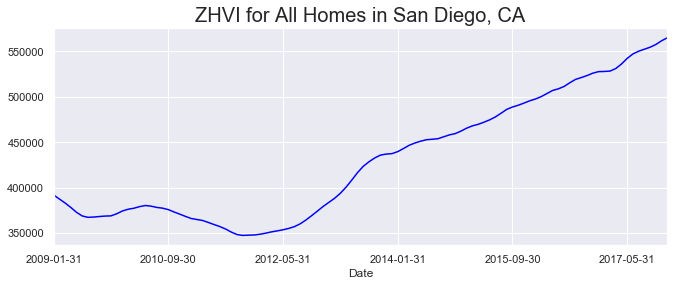

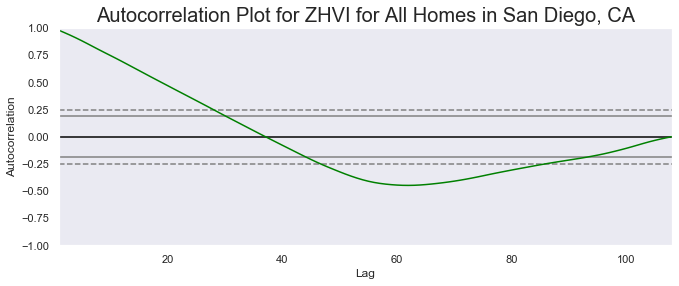

In [21]:
def plot_zhvi(cbsa_code):
    single_metro = metro_data.loc[metro_data['RegionName'] == cbsa_code]
    single_metro.plot(x = 'Date', y = 'ZHVI_AllHomes', color = 'blue', legend = None)
    plt.title('ZHVI for All Homes in ' + single_metro['MetroName'].iloc[0], fontsize = 20)
    plt.show()
    autocorrelation_plot(single_metro['ZHVI_AllHomes'], color = 'green')
    plt.title('Autocorrelation Plot for ZHVI for All Homes in ' + single_metro['MetroName'].iloc[0], fontsize = 20)
    
plot_zhvi(41740)

The **correlogram**, or autocorrelation plot, plots the sample correlations of the regression for each lag value. We want to choose a nonzero value of $p$ for our model such that the autocorrelation is high, so we can avoid overestimation or underestimation of true values for training of our forecasting model.

***
## Train ARIMA Model, Calculate Residual Errors and Residual Density

As soon as we are done fitting the model, we will have a summary of the fit. We have also ploptted the distributions for the residual errors, from which we can maybe capture some trend information. The density plot of the residual values show that they are Gaussian but not centred at zero. This is indicative of a bias in the prediction.

                             ARIMA Model Results                              
Dep. Variable:        D.ZHVI_AllHomes   No. Observations:                  107
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -866.530
Method:                       css-mle   S.D. of innovations            783.851
Date:                Wed, 04 Dec 2019   AIC                           1743.060
Time:                        13:48:52   BIC                           1756.424
Sample:                    02-28-2009   HQIC                          1748.478
                         - 12-31-2017                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1334.7795    955.254      1.397      0.165    -537.484    3207.043
ar.L1.D.ZHVI_AllHomes     1.0404      0.114      9.087      0.000       0.816       1.265
ar.L2.D.

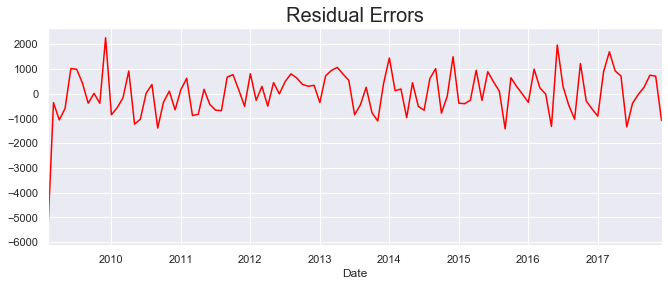

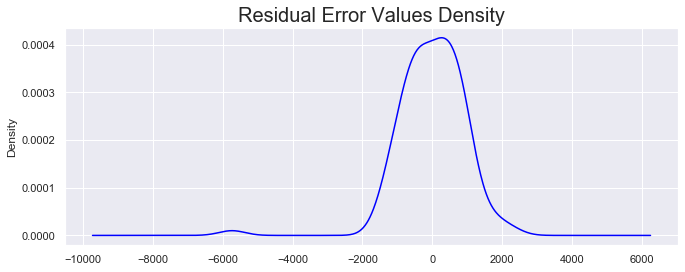

                 0
count   107.000000
mean     -0.596547
std     953.354623
min   -5734.779518
25%    -515.449563
50%      94.818294
75%     636.342513
max    2256.918216


In [28]:
def get_time_series(cbsa_code):
    series = metro_data.loc[metro_data['RegionName'] == cbsa_code].drop(columns = ['MetroName', 'RegionName'])
    series = series.set_index('Date')
    series.index = pd.to_datetime(series.index, format ='%Y-%m-%d')
    return series

from statsmodels.tsa.arima_model import ARIMA

series = get_time_series(41740)
arima_model = ARIMA(series, order = (2, 1, 1))
arima_model_fit = arima_model.fit(disp = 0)
print(arima_model_fit.summary())

residuals = DataFrame(arima_model_fit.resid)
residuals.plot(color = 'red', legend = None)
plt.title('Residual Errors', fontsize = 20)
plt.show()

residuals.plot(kind = 'kde', color = 'blue', legend = None)
plt.title('Residual Error Values Density', fontsize = 20)
plt.show()
print(residuals.describe())

***
## Test ARIMA Model

We now test our model and produce a 95% confidence interval for our forecasted results for the ZHVI in San Diego from 2017 to 2020. Note that there is a slight overlap with the in-sample and outsample predictions. 

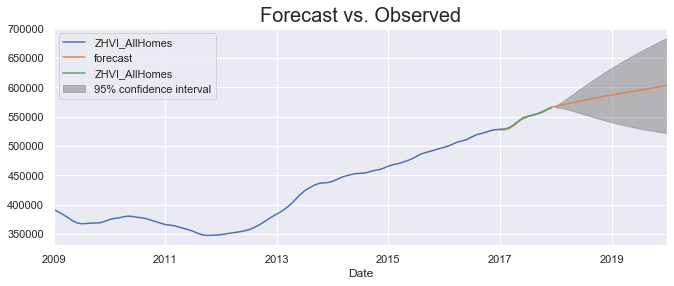

In [39]:
fig, ax = plt.subplots(figsize=(11, 4))
ax = series.loc['2009':].plot(ax = ax)
arima_model_fit.plot_predict('2017', '2020', dynamic=False, ax = ax, plot_insample = True)
plt.title('Forecast vs. Observed', fontsize = 20)
plt.show()

***
## Quantify Long-Term Recovery with 95% CI

Finally, we calculate the area of the confidence interval.

Area of Confidence Interval: 261224.30309147117


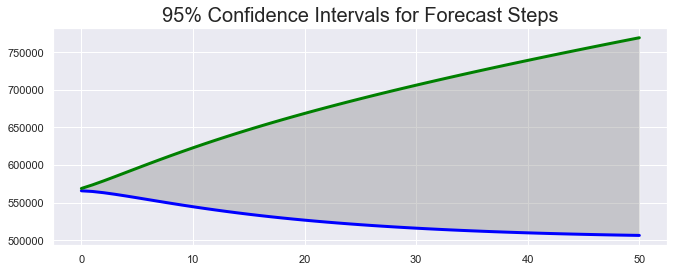

In [30]:
steps = 51
preds, stderr, ci = arima_model_fit.forecast(steps)
lower_bounds = [l[0] for l in ci]
upper_bounds = [u[1] for u in ci]

x = np.arange(steps)
plt.plot(x, lower_bounds, color = 'blue', lw = 3)
plt.plot(x, upper_bounds, color = 'green', lw = 3)
plt.fill_between(x, 
                 lower_bounds, 
                 upper_bounds, 
                 where = upper_bounds >= lower_bounds, 
                 facecolor = 'grey', 
                 alpha = 0.35)
plt.title('95% Confidence Intervals for Forecast Steps', fontsize = 20)

# Calculate the area
z = np.array(lower_bounds) - np.array(upper_bounds)
dx = x[1:] - x[:-1]
area = abs(z[:-1] + z[1:]) * 0.5 * dx
print('Area of Confidence Interval: ' + str(area[len(area) - 1]))

The **smaller** the area of the 95% confidence interval, the **less volatile the recovery over a longer period of time**, and the more certain we are that there will be a continuing increasing trend in the ZHVI.

## Generate CI Area for All Metros in Dataset

100%|██████████| 500/500 [00:36<00:00, 13.60it/s]

     Metro Area        CI Area  Normalised CI
182       20780  314743.528352       6.559009
236       24060  288462.471074       5.892760
99        16180  236514.934927       4.575841
120       17340  218968.538798       4.131023
104       16380  190299.388014       3.404234
..          ...            ...            ...
194       21500   15988.658009      -1.014707
490       39060   15966.263198      -1.015275
350       30780   14880.683613      -1.042795
46        12860   14648.820960      -1.048673
470       37900   12725.412415      -1.097433

[359 rows x 3 columns]


Text(0.5, 1.0, 'Normalised CI Distribution')

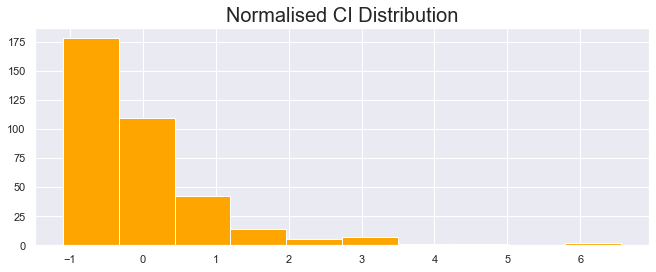

In [35]:
from tqdm import tqdm

def find_ci_area(metro, steps):
    series = get_time_series(metro)
    arima_model = ARIMA(series, order = (2, 1, 1))
    arima_model_fit = arima_model.fit(disp = 0, transparams = False)
    preds, stderr, ci = arima_model_fit.forecast(steps)
    lower_bounds = [l[0] for l in ci]
    upper_bounds = [u[1] for u in ci]

    # Calculate the area
    x = np.arange(steps)
    z = np.array(lower_bounds) - np.array(upper_bounds)
    dx = x[1:] - x[:-1]
    area = abs(z[:-1] + z[1:]) * 0.5 * dx
    return area[len(area) - 1]

# Change to whole population to run
metros = metro_data.head(500)['RegionName']
steps = 51
areas = []
new_metros = []

for m in tqdm(metros):
    try:
        areas.append(find_ci_area(m, steps))
        new_metros.append(m)
    except:
        pass

ar_df = pd.DataFrame({'Metro Area': new_metros, 'CI Area': areas})
norm_ci = (ar_df['CI Area'] - np.mean(ar_df['CI Area'])) / np.std(ar_df['CI Area'])
ar_df['Normalised CI'] = norm_ci
ar_df = ar_df.dropna().sort_values(by = 'Normalised CI', ascending = False)
print(ar_df)
hist = ar_df.hist(column = 'Normalised CI', color = 'orange')
plt.title('Normalised CI Distribution', fontsize = 20)